In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

DATASET_NAME = 'CIFAR100'    # CIFAR10, CIFAR100
DATASET_TYPE = 'baseline'   # baseline, custom

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')

['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'README.txt', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/866.2 kB 5.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 11.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1853, done.


remote: Counting objects: 100% (469/469), done.


remote: Compressing objects: 100% (296/296), done.


remote: Total 1853 (delta 191), reused 449 (delta 173), pack-reused 1384 (from 1)
Receiving objects: 100% (1853/1853), 725.68 MiB | 45.00 MiB/s, done.


Resolving deltas: 100% (854/854), done.


Updating files: 100% (172/172), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1725389619.605543      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR100...



  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 98304/169001437 [00:00<02:53, 973147.74it/s]

  1%|          | 917504/169001437 [00:00<00:32, 5095298.08it/s]

  4%|▍         | 6815744/169001437 [00:00<00:05, 28926948.62it/s]

  9%|▉         | 15237120/169001437 [00:00<00:03, 50369329.32it/s]

 14%|█▍        | 23494656/169001437 [00:00<00:02, 61615694.80it/s]

 19%|█▉        | 32145408/169001437 [00:00<00:01, 69931706.66it/s]

 24%|██▎       | 39911424/169001437 [00:00<00:01, 72418021.17it/s]

 29%|██▉       | 48889856/169001437 [00:00<00:01, 77897118.66it/s]

 34%|███▎      | 56754176/169001437 [00:00<00:01, 78074251.32it/s]

 39%|███▊      | 65273856/169001437 [00:01<00:01, 79268582.65it/s]

 44%|████▎     | 73859072/169001437 [00:01<00:01, 81206660.13it/s]

 49%|████▊     | 81985536/169001437 [00:01<00:01, 80485331.48it/s]

 54%|█████▎    | 90800128/169001437 [00:01<00:00, 82743717.96it/s]

 59%|█████▊    | 99090432/169001437 [00:01<00:00, 81937580.31it/s]

 63%|██████▎   | 107315200/169001437 [00:01<00:00, 81281728.53it/s]

 69%|██████▉   | 116260864/169001437 [00:01<00:00, 83649792.01it/s]

 74%|███████▍  | 124649472/169001437 [00:01<00:00, 82554297.52it/s]

 79%|███████▊  | 132939776/169001437 [00:01<00:00, 81551635.80it/s]

 84%|████████▍ | 141852672/169001437 [00:01<00:00, 83570899.07it/s]

 89%|████████▉ | 150241280/169001437 [00:02<00:00, 82577219.02it/s]

 94%|█████████▍| 158531584/169001437 [00:02<00:00, 81518125.75it/s]

 99%|█████████▉| 167444480/169001437 [00:02<00:00, 83638263.32it/s]

100%|██████████| 169001437/169001437 [00:02<00:00, 74493239.82it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 98304/169001437 [00:00<02:56, 959574.90it/s]

  1%|          | 917504/169001437 [00:00<00:33, 5049998.57it/s]

  4%|▎         | 6094848/169001437 [00:00<00:06, 25978028.47it/s]

  9%|▊         | 14450688/169001437 [00:00<00:03, 48164817.63it/s]

 13%|█▎        | 22446080/169001437 [00:00<00:02, 59463761.55it/s]

 18%|█▊        | 30343168/169001437 [00:00<00:02, 66013672.26it/s]

 23%|██▎       | 38371328/169001437 [00:00<00:01, 70606162.46it/s]

 28%|██▊       | 46661632/169001437 [00:00<00:01, 74481280.32it/s]

 32%|███▏      | 54460416/169001437 [00:00<00:01, 75477613.67it/s]

 37%|███▋      | 62717952/169001437 [00:01<00:01, 76856534.92it/s]

 42%|████▏     | 70877184/169001437 [00:01<00:01, 78264535.61it/s]

 47%|████▋     | 78839808/169001437 [00:01<00:01, 78626611.90it/s]

 52%|█████▏    | 87359488/169001437 [00:01<00:01, 80581178.11it/s]

 56%|█████▋    | 95453184/169001437 [00:01<00:00, 80349666.39it/s]

 61%|██████▏   | 103743488/169001437 [00:01<00:00, 81054567.73it/s]

 66%|██████▌   | 111869952/169001437 [00:01<00:00, 80638839.38it/s]

 71%|███████   | 119996416/169001437 [00:01<00:00, 80793246.25it/s]

 76%|███████▌  | 128090112/169001437 [00:01<00:00, 79133486.61it/s]

 81%|████████  | 136577024/169001437 [00:01<00:00, 80820172.59it/s]

 86%|████████▌ | 144670720/169001437 [00:02<00:00, 78872502.42it/s]

 91%|█████████ | 152961024/169001437 [00:02<00:00, 80005728.45it/s]

 95%|█████████▌| 160989184/169001437 [00:02<00:00, 79089351.17it/s]

100%|██████████| 169001437/169001437 [00:02<00:00, 79110668.42it/s]

100%|██████████| 169001437/169001437 [00:02<00:00, 72243051.51it/s]

Extracting ./data/train/cifar-100-python.tar.gz to ./data/train


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 131072/169001437 [00:00<02:09, 1306407.36it/s]

  1%|          | 917504/169001437 [00:00<00:32, 5154409.12it/s]

  4%|▍         | 6619136/169001437 [00:00<00:05, 28387904.95it/s]

  7%|▋         | 12582912/169001437 [00:00<00:03, 40421859.73it/s]

 12%|█▏        | 19464192/169001437 [00:00<00:02, 50470332.55it/s]

 15%|█▌        | 26017792/169001437 [00:00<00:02, 55454081.56it/s]

 19%|█▉        | 32505856/169001437 [00:00<00:02, 58377707.15it/s]

 23%|██▎       | 39616512/169001437 [00:00<00:02, 62402428.44it/s]

 27%|██▋       | 45875200/169001437 [00:00<00:02, 61434780.68it/s]

 32%|███▏      | 53313536/169001437 [00:01<00:01, 65341325.93it/s]

 35%|███▌      | 59867136/169001437 [00:01<00:01, 63455152.11it/s]

 39%|███▉      | 66715648/169001437 [00:01<00:01, 64851907.72it/s]

 44%|████▍     | 74579968/169001437 [00:01<00:01, 68930520.99it/s]

 49%|████▉     | 82575360/169001437 [00:01<00:01, 72092053.13it/s]

 54%|█████▎    | 90603520/169001437 [00:01<00:01, 74487748.28it/s]

 58%|█████▊    | 98402304/169001437 [00:01<00:00, 75431897.22it/s]

 63%|██████▎   | 105971712/169001437 [00:01<00:00, 75268512.37it/s]

 67%|██████▋   | 113737728/169001437 [00:01<00:00, 75935804.54it/s]

 72%|███████▏  | 121339904/169001437 [00:01<00:00, 73697635.12it/s]

 76%|███████▌  | 128745472/169001437 [00:02<00:00, 63074132.52it/s]

 80%|████████  | 135626752/169001437 [00:02<00:00, 64581606.01it/s]

 84%|████████▍ | 142508032/169001437 [00:02<00:00, 65601772.57it/s]

 89%|████████▊ | 149848064/169001437 [00:02<00:00, 67682360.07it/s]

 93%|█████████▎| 157122560/169001437 [00:02<00:00, 69118920.89it/s]

 97%|█████████▋| 164429824/169001437 [00:02<00:00, 70231691.68it/s]

100%|██████████| 169001437/169001437 [00:02<00:00, 63566164.82it/s]

Extracting ./data/test/cifar-100-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


Dataset type "baseline" displaying...



fox   sea   apple bee   skunk bear  skyscraper otter cloud bottle man   clock bear  bottle aquarium_fish beaver shark skyscraper rabbit worm  crab  bear  ray   shrew seal  tulip maple_tree lizard lawn_mower oak_tree pine_tree maple_tree can   worm  bear  orchid train willow_tree tractor caterpillar tractor hamster tulip woman pear  table shrew otter sweet_pepper keyboard lion  television snake turtle raccoon oak_tree mountain sunflower possum flatfish fox   squirrel turtle wolf  cup   palm_tree poppy snail can   flatfish clock maple_tree turtle boy   rose  lobster rabbit man   porcupine dolphin otter pine_tree maple_tree streetcar maple_tree butterfly turtle apple woman seal  tractor kangaroo lizard orchid bee   couch forest television aquarium_fish tiger road  whale house apple sea   whale sea   bottle forest pine_tree train clock snake television keyboard orange dinosaur snake couch beetle tractor shark cup   maple_tree whale ray   lamp  forest streetcar mountain couch snail hamster 

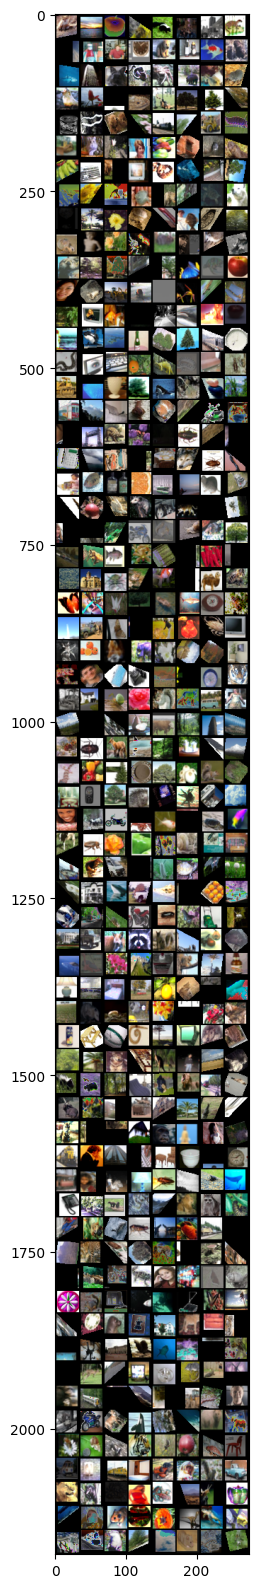

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
def soft_loss2(pred, label, confidence):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1)
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    # Compute weighted KL loss
    kl = confidence * F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)        # Weighted
#     kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)                   # Unweighted
    
#     print(f'log_prob: {log_prob}\none_hot: {one_hot}\nkl: {F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)}')
    return kl.mean()



# def soft_loss2(pred, label, confidence):
#     label = label.unsqueeze(1)
#     target = label.long()
#     confidence = confidence.unsqueeze(1).float()
#     prob = (1 - (label - target))
#     weight = torch.ones_like(prob).float()
#     n_classes = pred.size(1)

#     # one_hot = (torch.ones_like(pred) * (1 - confidence) / (n_classes - 1)).float()
#     # one_hot.scatter_(dim=1, index=target, src=confidence)
#     one_hot = torch.zeros_like(pred).float()
#     one_hot.scatter_(dim=1, index=torch.ones_like(target)*(n_classes - 1), src=(1 - prob.float()))
#     one_hot.scatter_(dim=1, index=target, src=prob.float())
#     log_prob = F.log_softmax(pred, dim=1)
#     kl = confidence * F.kl_div(input=log_prob.float(), target=one_hot.float(), reduction='none').sum(-1)
#     return kl.mean()

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 200
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    for i, (inputs, labels) in enumerate(baseline_trainloader):
#     for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        if DATASET_TYPE=='custom' and confidences is None:
            raise ValueError('Dataset type do not match data loader')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
#         only when TA with soft labels is applied
            
        # get the inputs
        if confidences is not None:
            confidences = confidences.to(device)
            
        if isinstance(confidences, list):
            confidences = confidences[1]
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
#         print(f'pred: {outputs}\tlabel: {labels}\tconf: {confidences}')
        if DATASET_TYPE=='custom':
            loss = soft_loss2(pred=outputs, label=labels, confidence=confidences)
        else:
            loss = criterion(outputs, labels)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hloss:.3f}')

        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...




Epoch 1 - Loss: 4.308 - Test Accuracy:  6.440

Processing time:  78.393893 seconds.



Epoch 2 - Loss: 3.975 - Test Accuracy:  9.970

Processing time:  40.465764 seconds.



Epoch 3 - Loss: 3.769 - Test Accuracy:  12.470

Processing time:  21.093240 seconds.



Epoch 4 - Loss: 3.537 - Test Accuracy:  14.440

Processing time:  21.100595 seconds.



Epoch 5 - Loss: 3.306 - Test Accuracy:  16.010

Processing time:  21.169434 seconds.



Epoch 6 - Loss: 3.096 - Test Accuracy:  21.060

Processing time:  21.620121 seconds.



Epoch 7 - Loss: 2.897 - Test Accuracy:  27.540

Processing time:  21.603127 seconds.



Epoch 8 - Loss: 2.747 - Test Accuracy:  36.130

Processing time:  21.578357 seconds.



Epoch 9 - Loss: 2.581 - Test Accuracy:  31.170

Processing time:  21.348000 seconds.



Epoch 10 - Loss: 2.466 - Test Accuracy:  40.040

Processing time:  21.483561 seconds.



Epoch 11 - Loss: 2.360 - Test Accuracy:  37.920

Processing time:  21.525836 seconds.



Epoch 12 - Loss: 2.265 - Test Accuracy:  44.510

Processing time:  21.411358 seconds.



Epoch 13 - Loss: 2.176 - Test Accuracy:  40.600

Processing time:  21.358589 seconds.



Epoch 14 - Loss: 2.104 - Test Accuracy:  37.430

Processing time:  21.258897 seconds.



Epoch 15 - Loss: 2.038 - Test Accuracy:  46.510

Processing time:  21.126293 seconds.



Epoch 16 - Loss: 1.987 - Test Accuracy:  49.680

Processing time:  22.310013 seconds.



Epoch 17 - Loss: 1.925 - Test Accuracy:  51.980

Processing time:  21.546735 seconds.



Epoch 18 - Loss: 1.875 - Test Accuracy:  50.710

Processing time:  21.382944 seconds.



Epoch 19 - Loss: 1.824 - Test Accuracy:  50.340

Processing time:  21.557777 seconds.



Epoch 20 - Loss: 1.797 - Test Accuracy:  48.470

Processing time:  21.599576 seconds.



Epoch 21 - Loss: 1.744 - Test Accuracy:  56.090

Processing time:  21.385150 seconds.



Epoch 22 - Loss: 1.726 - Test Accuracy:  54.790

Processing time:  21.386883 seconds.



Epoch 23 - Loss: 1.685 - Test Accuracy:  53.990

Processing time:  21.355874 seconds.



Epoch 24 - Loss: 1.650 - Test Accuracy:  57.170

Processing time:  21.540011 seconds.



Epoch 25 - Loss: 1.621 - Test Accuracy:  57.590

Processing time:  21.378254 seconds.



Epoch 26 - Loss: 1.604 - Test Accuracy:  52.990

Processing time:  21.043458 seconds.



Epoch 27 - Loss: 1.568 - Test Accuracy:  61.520

Processing time:  21.680001 seconds.



Epoch 28 - Loss: 1.538 - Test Accuracy:  55.040

Processing time:  21.602842 seconds.



Epoch 29 - Loss: 1.532 - Test Accuracy:  58.640

Processing time:  21.573752 seconds.



Epoch 30 - Loss: 1.493 - Test Accuracy:  61.130

Processing time:  21.455064 seconds.



Epoch 31 - Loss: 1.480 - Test Accuracy:  59.640

Processing time:  21.359681 seconds.



Epoch 32 - Loss: 1.447 - Test Accuracy:  55.400

Processing time:  21.638283 seconds.



Epoch 33 - Loss: 1.452 - Test Accuracy:  63.990

Processing time:  21.446515 seconds.



Epoch 34 - Loss: 1.417 - Test Accuracy:  63.890

Processing time:  21.809254 seconds.



Epoch 35 - Loss: 1.409 - Test Accuracy:  63.710

Processing time:  21.593076 seconds.



Epoch 36 - Loss: 1.399 - Test Accuracy:  59.470

Processing time:  21.591888 seconds.



Epoch 37 - Loss: 1.374 - Test Accuracy:  63.930

Processing time:  21.382385 seconds.



Epoch 38 - Loss: 1.361 - Test Accuracy:  65.330

Processing time:  21.535458 seconds.



Epoch 39 - Loss: 1.337 - Test Accuracy:  63.390

Processing time:  21.612993 seconds.



Epoch 40 - Loss: 1.327 - Test Accuracy:  66.350

Processing time:  21.531681 seconds.



Epoch 41 - Loss: 1.309 - Test Accuracy:  65.230

Processing time:  21.544778 seconds.



Epoch 42 - Loss: 1.301 - Test Accuracy:  62.040

Processing time:  21.450440 seconds.



Epoch 43 - Loss: 1.300 - Test Accuracy:  64.300

Processing time:  21.695556 seconds.



Epoch 44 - Loss: 1.280 - Test Accuracy:  63.410

Processing time:  21.305169 seconds.



Epoch 45 - Loss: 1.264 - Test Accuracy:  63.620

Processing time:  21.300419 seconds.



Epoch 46 - Loss: 1.248 - Test Accuracy:  66.100

Processing time:  21.153164 seconds.



Epoch 47 - Loss: 1.241 - Test Accuracy:  68.110

Processing time:  21.149621 seconds.



Epoch 48 - Loss: 1.233 - Test Accuracy:  66.440

Processing time:  21.696948 seconds.



Epoch 49 - Loss: 1.218 - Test Accuracy:  66.810

Processing time:  21.732327 seconds.



Epoch 50 - Loss: 1.202 - Test Accuracy:  67.390

Processing time:  21.533541 seconds.



Epoch 51 - Loss: 1.203 - Test Accuracy:  67.210

Processing time:  21.451956 seconds.



Epoch 52 - Loss: 1.189 - Test Accuracy:  66.450

Processing time:  21.404513 seconds.



Epoch 53 - Loss: 1.183 - Test Accuracy:  68.190

Processing time:  21.291636 seconds.



Epoch 54 - Loss: 1.163 - Test Accuracy:  66.390

Processing time:  21.523266 seconds.



Epoch 55 - Loss: 1.159 - Test Accuracy:  69.170

Processing time:  21.386262 seconds.



Epoch 56 - Loss: 1.150 - Test Accuracy:  69.540

Processing time:  21.201931 seconds.



Epoch 57 - Loss: 1.144 - Test Accuracy:  69.030

Processing time:  21.167139 seconds.



Epoch 58 - Loss: 1.133 - Test Accuracy:  67.110

Processing time:  21.834534 seconds.



Epoch 59 - Loss: 1.133 - Test Accuracy:  67.670

Processing time:  21.645780 seconds.



Epoch 60 - Loss: 1.119 - Test Accuracy:  68.550

Processing time:  21.557960 seconds.



Epoch 61 - Loss: 1.104 - Test Accuracy:  70.020

Processing time:  21.569031 seconds.



Epoch 62 - Loss: 1.107 - Test Accuracy:  68.640

Processing time:  21.402604 seconds.



Epoch 63 - Loss: 1.094 - Test Accuracy:  69.550

Processing time:  21.529325 seconds.



Epoch 64 - Loss: 1.077 - Test Accuracy:  69.330

Processing time:  21.615702 seconds.



Epoch 65 - Loss: 1.063 - Test Accuracy:  69.710

Processing time:  21.598878 seconds.



Epoch 66 - Loss: 1.062 - Test Accuracy:  67.420

Processing time:  21.485911 seconds.



Epoch 67 - Loss: 1.065 - Test Accuracy:  67.910

Processing time:  21.655298 seconds.



Epoch 68 - Loss: 1.048 - Test Accuracy:  69.540

Processing time:  21.596665 seconds.



Epoch 69 - Loss: 1.040 - Test Accuracy:  69.170

Processing time:  21.445122 seconds.



Epoch 70 - Loss: 1.047 - Test Accuracy:  67.700

Processing time:  21.387482 seconds.



Epoch 71 - Loss: 1.024 - Test Accuracy:  71.010

Processing time:  21.593209 seconds.



Epoch 72 - Loss: 1.018 - Test Accuracy:  68.400

Processing time:  21.012805 seconds.



Epoch 73 - Loss: 1.007 - Test Accuracy:  68.190

Processing time:  21.702824 seconds.



Epoch 74 - Loss: 1.001 - Test Accuracy:  71.060

Processing time:  21.171567 seconds.



Epoch 75 - Loss: 1.005 - Test Accuracy:  70.190

Processing time:  21.403062 seconds.



Epoch 76 - Loss: 0.990 - Test Accuracy:  70.060

Processing time:  21.187178 seconds.



Epoch 77 - Loss: 0.990 - Test Accuracy:  68.560

Processing time:  21.247981 seconds.



Epoch 78 - Loss: 0.969 - Test Accuracy:  70.940

Processing time:  21.064384 seconds.



Epoch 79 - Loss: 0.976 - Test Accuracy:  70.620

Processing time:  21.344296 seconds.



Epoch 80 - Loss: 0.967 - Test Accuracy:  68.820

Processing time:  21.108538 seconds.



Epoch 81 - Loss: 0.955 - Test Accuracy:  69.740

Processing time:  21.140967 seconds.



Epoch 82 - Loss: 0.945 - Test Accuracy:  69.310

Processing time:  21.132654 seconds.



Epoch 83 - Loss: 0.960 - Test Accuracy:  70.790

Processing time:  21.508551 seconds.



Epoch 84 - Loss: 0.934 - Test Accuracy:  68.900

Processing time:  21.649590 seconds.



Epoch 85 - Loss: 0.940 - Test Accuracy:  70.740

Processing time:  21.582491 seconds.



Epoch 86 - Loss: 0.920 - Test Accuracy:  71.920

Processing time:  21.486094 seconds.



Epoch 87 - Loss: 0.931 - Test Accuracy:  70.020

Processing time:  21.472785 seconds.



Epoch 88 - Loss: 0.909 - Test Accuracy:  71.110

Processing time:  21.439720 seconds.



Epoch 89 - Loss: 0.897 - Test Accuracy:  71.360

Processing time:  21.670945 seconds.



Epoch 90 - Loss: 0.898 - Test Accuracy:  71.580

Processing time:  21.556189 seconds.



Epoch 91 - Loss: 0.896 - Test Accuracy:  71.520

Processing time:  21.368948 seconds.



Epoch 92 - Loss: 0.887 - Test Accuracy:  71.570

Processing time:  21.490366 seconds.



Epoch 93 - Loss: 0.865 - Test Accuracy:  72.820

Processing time:  21.433964 seconds.



Epoch 94 - Loss: 0.868 - Test Accuracy:  72.350

Processing time:  21.423960 seconds.



Epoch 95 - Loss: 0.873 - Test Accuracy:  71.900

Processing time:  21.510348 seconds.



Epoch 96 - Loss: 0.866 - Test Accuracy:  72.000

Processing time:  21.440274 seconds.



Epoch 97 - Loss: 0.848 - Test Accuracy:  71.770

Processing time:  21.334387 seconds.



Epoch 98 - Loss: 0.845 - Test Accuracy:  71.950

Processing time:  21.653351 seconds.



Epoch 99 - Loss: 0.843 - Test Accuracy:  73.140

Processing time:  21.514632 seconds.



Epoch 100 - Loss: 0.838 - Test Accuracy:  71.770

Processing time:  21.464599 seconds.



Epoch 101 - Loss: 0.830 - Test Accuracy:  74.000

Processing time:  21.586056 seconds.



Epoch 102 - Loss: 0.824 - Test Accuracy:  72.790

Processing time:  21.420771 seconds.



Epoch 103 - Loss: 0.813 - Test Accuracy:  72.840

Processing time:  21.433216 seconds.



Epoch 104 - Loss: 0.813 - Test Accuracy:  73.230

Processing time:  21.408147 seconds.



Epoch 105 - Loss: 0.807 - Test Accuracy:  72.740

Processing time:  21.464966 seconds.



Epoch 106 - Loss: 0.796 - Test Accuracy:  73.340

Processing time:  21.388954 seconds.



Epoch 107 - Loss: 0.795 - Test Accuracy:  73.580

Processing time:  21.262228 seconds.



Epoch 108 - Loss: 0.801 - Test Accuracy:  72.690

Processing time:  21.225427 seconds.



Epoch 109 - Loss: 0.778 - Test Accuracy:  73.030

Processing time:  21.119197 seconds.



Epoch 110 - Loss: 0.777 - Test Accuracy:  73.390

Processing time:  20.953449 seconds.



Epoch 111 - Loss: 0.774 - Test Accuracy:  73.390

Processing time:  21.121039 seconds.



Epoch 112 - Loss: 0.762 - Test Accuracy:  73.300

Processing time:  21.030203 seconds.



Epoch 113 - Loss: 0.765 - Test Accuracy:  73.560

Processing time:  21.119487 seconds.



Epoch 114 - Loss: 0.756 - Test Accuracy:  73.390

Processing time:  21.076885 seconds.



Epoch 115 - Loss: 0.757 - Test Accuracy:  74.360

Processing time:  21.066347 seconds.



Epoch 116 - Loss: 0.743 - Test Accuracy:  74.220

Processing time:  21.216195 seconds.



Epoch 117 - Loss: 0.742 - Test Accuracy:  73.160

Processing time:  21.478722 seconds.



Epoch 118 - Loss: 0.734 - Test Accuracy:  74.400

Processing time:  21.438108 seconds.



Epoch 119 - Loss: 0.732 - Test Accuracy:  73.150

Processing time:  21.628197 seconds.



Epoch 120 - Loss: 0.713 - Test Accuracy:  74.830

Processing time:  21.554579 seconds.



Epoch 121 - Loss: 0.711 - Test Accuracy:  75.250

Processing time:  21.643206 seconds.



Epoch 122 - Loss: 0.701 - Test Accuracy:  75.230

Processing time:  21.382185 seconds.



Epoch 123 - Loss: 0.698 - Test Accuracy:  75.120

Processing time:  21.408624 seconds.



Epoch 124 - Loss: 0.699 - Test Accuracy:  75.120

Processing time:  21.393399 seconds.



Epoch 125 - Loss: 0.691 - Test Accuracy:  74.980

Processing time:  21.344597 seconds.



Epoch 126 - Loss: 0.681 - Test Accuracy:  74.890

Processing time:  21.408020 seconds.



Epoch 127 - Loss: 0.670 - Test Accuracy:  75.110

Processing time:  21.188504 seconds.



Epoch 128 - Loss: 0.677 - Test Accuracy:  74.330

Processing time:  21.754815 seconds.



Epoch 129 - Loss: 0.680 - Test Accuracy:  75.980

Processing time:  21.587010 seconds.



Epoch 130 - Loss: 0.666 - Test Accuracy:  74.430

Processing time:  21.353050 seconds.



Epoch 131 - Loss: 0.663 - Test Accuracy:  75.020

Processing time:  21.187894 seconds.



Epoch 132 - Loss: 0.651 - Test Accuracy:  74.630

Processing time:  21.371850 seconds.



Epoch 133 - Loss: 0.650 - Test Accuracy:  75.560

Processing time:  21.574178 seconds.



Epoch 134 - Loss: 0.646 - Test Accuracy:  75.380

Processing time:  21.447190 seconds.



Epoch 135 - Loss: 0.648 - Test Accuracy:  75.510

Processing time:  21.457850 seconds.



Epoch 136 - Loss: 0.636 - Test Accuracy:  75.850

Processing time:  21.358491 seconds.



Epoch 137 - Loss: 0.624 - Test Accuracy:  75.360

Processing time:  21.848685 seconds.



Epoch 138 - Loss: 0.630 - Test Accuracy:  75.750

Processing time:  21.630511 seconds.



Epoch 139 - Loss: 0.621 - Test Accuracy:  76.050

Processing time:  21.528087 seconds.



Epoch 140 - Loss: 0.616 - Test Accuracy:  75.570

Processing time:  21.477330 seconds.



Epoch 141 - Loss: 0.609 - Test Accuracy:  75.870

Processing time:  21.691973 seconds.



Epoch 142 - Loss: 0.618 - Test Accuracy:  75.490

Processing time:  21.208390 seconds.



Epoch 143 - Loss: 0.605 - Test Accuracy:  75.310

Processing time:  21.181605 seconds.



Epoch 144 - Loss: 0.588 - Test Accuracy:  76.250

Processing time:  21.477852 seconds.



Epoch 145 - Loss: 0.594 - Test Accuracy:  76.530

Processing time:  21.517740 seconds.



Epoch 146 - Loss: 0.586 - Test Accuracy:  76.270

Processing time:  21.386517 seconds.



Epoch 147 - Loss: 0.595 - Test Accuracy:  76.240

Processing time:  21.343040 seconds.



Epoch 148 - Loss: 0.585 - Test Accuracy:  76.780

Processing time:  21.405107 seconds.



Epoch 149 - Loss: 0.566 - Test Accuracy:  76.370

Processing time:  21.410807 seconds.



Epoch 150 - Loss: 0.573 - Test Accuracy:  76.650

Processing time:  21.184953 seconds.



Epoch 151 - Loss: 0.576 - Test Accuracy:  76.480

Processing time:  21.908255 seconds.



Epoch 152 - Loss: 0.566 - Test Accuracy:  76.710

Processing time:  21.498908 seconds.



Epoch 153 - Loss: 0.556 - Test Accuracy:  77.070

Processing time:  21.697920 seconds.



Epoch 154 - Loss: 0.559 - Test Accuracy:  77.350

Processing time:  21.405665 seconds.



Epoch 155 - Loss: 0.552 - Test Accuracy:  77.070

Processing time:  21.452266 seconds.



Epoch 156 - Loss: 0.550 - Test Accuracy:  76.920

Processing time:  21.417148 seconds.



Epoch 157 - Loss: 0.541 - Test Accuracy:  77.400

Processing time:  21.308731 seconds.



Epoch 158 - Loss: 0.549 - Test Accuracy:  77.490

Processing time:  21.179451 seconds.



Epoch 159 - Loss: 0.536 - Test Accuracy:  77.230

Processing time:  21.250468 seconds.



Epoch 160 - Loss: 0.527 - Test Accuracy:  78.140

Processing time:  21.244764 seconds.



Epoch 161 - Loss: 0.532 - Test Accuracy:  77.740

Processing time:  21.059174 seconds.



Epoch 162 - Loss: 0.529 - Test Accuracy:  77.510

Processing time:  21.338667 seconds.



Epoch 163 - Loss: 0.521 - Test Accuracy:  77.450

Processing time:  21.755439 seconds.



Epoch 164 - Loss: 0.523 - Test Accuracy:  77.380

Processing time:  21.666643 seconds.



Epoch 165 - Loss: 0.515 - Test Accuracy:  77.520

Processing time:  21.505343 seconds.



Epoch 166 - Loss: 0.520 - Test Accuracy:  77.340

Processing time:  21.394956 seconds.



Epoch 167 - Loss: 0.510 - Test Accuracy:  77.630

Processing time:  21.408078 seconds.



Epoch 168 - Loss: 0.507 - Test Accuracy:  78.040

Processing time:  21.504953 seconds.



Epoch 169 - Loss: 0.508 - Test Accuracy:  77.950

Processing time:  22.347018 seconds.



Epoch 170 - Loss: 0.505 - Test Accuracy:  77.640

Processing time:  21.454280 seconds.



Epoch 171 - Loss: 0.501 - Test Accuracy:  78.020

Processing time:  21.248895 seconds.



Epoch 172 - Loss: 0.502 - Test Accuracy:  77.870

Processing time:  21.353623 seconds.



Epoch 173 - Loss: 0.486 - Test Accuracy:  77.740

Processing time:  21.314534 seconds.



Epoch 174 - Loss: 0.492 - Test Accuracy:  78.240

Processing time:  21.291423 seconds.



Epoch 175 - Loss: 0.489 - Test Accuracy:  77.870

Processing time:  21.628804 seconds.



Epoch 176 - Loss: 0.490 - Test Accuracy:  78.200

Processing time:  21.485037 seconds.



Epoch 177 - Loss: 0.489 - Test Accuracy:  77.950

Processing time:  21.372778 seconds.



Epoch 178 - Loss: 0.488 - Test Accuracy:  78.190

Processing time:  21.046093 seconds.



Epoch 179 - Loss: 0.479 - Test Accuracy:  78.170

Processing time:  21.388659 seconds.



Epoch 180 - Loss: 0.493 - Test Accuracy:  78.270

Processing time:  21.503077 seconds.



Epoch 181 - Loss: 0.486 - Test Accuracy:  78.100

Processing time:  21.598918 seconds.



Epoch 182 - Loss: 0.485 - Test Accuracy:  78.190

Processing time:  21.357610 seconds.



Epoch 183 - Loss: 0.473 - Test Accuracy:  78.380

Processing time:  21.245123 seconds.



Epoch 184 - Loss: 0.482 - Test Accuracy:  78.210

Processing time:  21.347855 seconds.



Epoch 185 - Loss: 0.477 - Test Accuracy:  78.210

Processing time:  22.612054 seconds.



Epoch 186 - Loss: 0.468 - Test Accuracy:  78.290

Processing time:  21.630306 seconds.



Epoch 187 - Loss: 0.476 - Test Accuracy:  78.380

Processing time:  22.003117 seconds.



Epoch 188 - Loss: 0.467 - Test Accuracy:  78.280

Processing time:  21.265535 seconds.



Epoch 189 - Loss: 0.466 - Test Accuracy:  78.240

Processing time:  21.252908 seconds.



Epoch 190 - Loss: 0.478 - Test Accuracy:  78.180

Processing time:  21.468373 seconds.



Epoch 191 - Loss: 0.464 - Test Accuracy:  78.270

Processing time:  21.612716 seconds.



Epoch 192 - Loss: 0.469 - Test Accuracy:  78.230

Processing time:  21.426351 seconds.



Epoch 193 - Loss: 0.473 - Test Accuracy:  78.380

Processing time:  21.151450 seconds.



Epoch 194 - Loss: 0.476 - Test Accuracy:  78.430

Processing time:  21.636144 seconds.



Epoch 195 - Loss: 0.474 - Test Accuracy:  78.380

Processing time:  21.497343 seconds.



Epoch 196 - Loss: 0.471 - Test Accuracy:  78.460

Processing time:  21.441237 seconds.



Epoch 197 - Loss: 0.467 - Test Accuracy:  78.390

Processing time:  21.771329 seconds.



Epoch 198 - Loss: 0.469 - Test Accuracy:  78.410

Processing time:  21.385035 seconds.



Epoch 199 - Loss: 0.470 - Test Accuracy:  78.400

Processing time:  21.238843 seconds.



Epoch 200 - Loss: 0.471 - Test Accuracy:  78.410

Processing time:  22.140718 seconds.
Finished Training


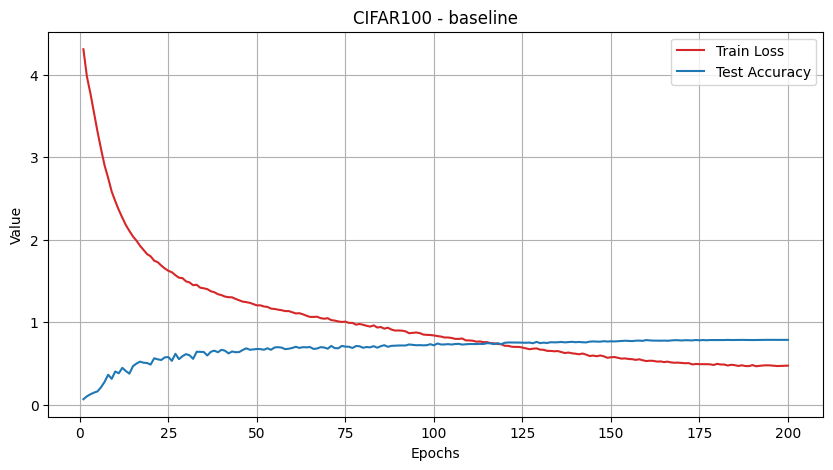

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 78.41 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 60.12 %


Accuracy of the network on gaussian_noise dataset split 2: 44.35 %


Accuracy of the network on gaussian_noise dataset split 3: 30.82 %


Accuracy of the network on gaussian_noise dataset split 4: 25.20 %


Accuracy of the network on gaussian_noise dataset split 5: 20.93 %
Average accuracy for gaussian_noise dataset: 36.28 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 67.19 %


Accuracy of the network on shot_noise dataset split 2: 58.37 %


Accuracy of the network on shot_noise dataset split 3: 40.20 %


Accuracy of the network on shot_noise dataset split 4: 33.49 %


Accuracy of the network on shot_noise dataset split 5: 24.18 %
Average accuracy for shot_noise dataset: 44.69 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 74.55 %


Accuracy of the network on impulse_noise dataset split 2: 67.77 %


Accuracy of the network on impulse_noise dataset split 3: 58.81 %


Accuracy of the network on impulse_noise dataset split 4: 37.81 %


Accuracy of the network on impulse_noise dataset split 5: 22.24 %
Average accuracy for impulse_noise dataset: 52.24 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 78.08 %


Accuracy of the network on defocus_blur dataset split 2: 76.46 %


Accuracy of the network on defocus_blur dataset split 3: 73.21 %


Accuracy of the network on defocus_blur dataset split 4: 68.03 %


Accuracy of the network on defocus_blur dataset split 5: 54.72 %
Average accuracy for defocus_blur dataset: 70.10 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 53.38 %


Accuracy of the network on glass_blur dataset split 2: 55.10 %


Accuracy of the network on glass_blur dataset split 3: 57.15 %


Accuracy of the network on glass_blur dataset split 4: 37.24 %


Accuracy of the network on glass_blur dataset split 5: 41.83 %
Average accuracy for glass_blur dataset: 48.94 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 73.32 %


Accuracy of the network on motion_blur dataset split 2: 67.36 %


Accuracy of the network on motion_blur dataset split 3: 59.04 %


Accuracy of the network on motion_blur dataset split 4: 59.81 %


Accuracy of the network on motion_blur dataset split 5: 50.95 %
Average accuracy for motion_blur dataset: 62.10 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 72.97 %


Accuracy of the network on zoom_blur dataset split 2: 71.74 %


Accuracy of the network on zoom_blur dataset split 3: 68.79 %


Accuracy of the network on zoom_blur dataset split 4: 65.14 %


Accuracy of the network on zoom_blur dataset split 5: 59.04 %
Average accuracy for zoom_blur dataset: 67.54 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 73.99 %


Accuracy of the network on snow dataset split 2: 64.38 %


Accuracy of the network on snow dataset split 3: 65.30 %


Accuracy of the network on snow dataset split 4: 62.66 %


Accuracy of the network on snow dataset split 5: 56.40 %
Average accuracy for snow dataset: 64.55 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 71.80 %


Accuracy of the network on frost dataset split 2: 64.81 %


Accuracy of the network on frost dataset split 3: 54.27 %


Accuracy of the network on frost dataset split 4: 52.35 %


Accuracy of the network on frost dataset split 5: 43.43 %
Average accuracy for frost dataset: 57.33 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 78.09 %


Accuracy of the network on fog dataset split 2: 75.62 %


Accuracy of the network on fog dataset split 3: 72.79 %


Accuracy of the network on fog dataset split 4: 66.50 %


Accuracy of the network on fog dataset split 5: 45.75 %
Average accuracy for fog dataset: 67.75 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 77.95 %


Accuracy of the network on brightness dataset split 2: 77.54 %


Accuracy of the network on brightness dataset split 3: 76.53 %


Accuracy of the network on brightness dataset split 4: 75.20 %


Accuracy of the network on brightness dataset split 5: 70.81 %
Average accuracy for brightness dataset: 75.61 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 77.61 %


Accuracy of the network on contrast dataset split 2: 74.86 %


Accuracy of the network on contrast dataset split 3: 72.31 %


Accuracy of the network on contrast dataset split 4: 68.42 %


Accuracy of the network on contrast dataset split 5: 54.85 %
Average accuracy for contrast dataset: 69.61 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 71.92 %


Accuracy of the network on elastic_transform dataset split 2: 71.82 %


Accuracy of the network on elastic_transform dataset split 3: 69.88 %


Accuracy of the network on elastic_transform dataset split 4: 62.17 %


Accuracy of the network on elastic_transform dataset split 5: 53.33 %
Average accuracy for elastic_transform dataset: 65.82 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 74.62 %


Accuracy of the network on pixelate dataset split 2: 66.86 %


Accuracy of the network on pixelate dataset split 3: 60.57 %


Accuracy of the network on pixelate dataset split 4: 38.21 %


Accuracy of the network on pixelate dataset split 5: 15.47 %
Average accuracy for pixelate dataset: 51.15 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 63.85 %


Accuracy of the network on jpeg_compression dataset split 2: 55.64 %


Accuracy of the network on jpeg_compression dataset split 3: 52.97 %


Accuracy of the network on jpeg_compression dataset split 4: 49.36 %


Accuracy of the network on jpeg_compression dataset split 5: 46.20 %
Average accuracy for jpeg_compression dataset: 53.60 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 67.79 %


Accuracy of the network on speckle_noise dataset split 2: 54.30 %


Accuracy of the network on speckle_noise dataset split 3: 48.06 %


Accuracy of the network on speckle_noise dataset split 4: 35.85 %


Accuracy of the network on speckle_noise dataset split 5: 26.08 %
Average accuracy for speckle_noise dataset: 46.42 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 78.03 %


Accuracy of the network on gaussian_blur dataset split 2: 73.14 %


Accuracy of the network on gaussian_blur dataset split 3: 69.32 %


Accuracy of the network on gaussian_blur dataset split 4: 64.16 %


Accuracy of the network on gaussian_blur dataset split 5: 49.10 %
Average accuracy for gaussian_blur dataset: 66.75 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 76.01 %


Accuracy of the network on spatter dataset split 2: 71.70 %


Accuracy of the network on spatter dataset split 3: 64.91 %


Accuracy of the network on spatter dataset split 4: 70.76 %


Accuracy of the network on spatter dataset split 5: 61.55 %
Average accuracy for spatter dataset: 68.99 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 72.30 %


Accuracy of the network on saturate dataset split 2: 66.07 %


Accuracy of the network on saturate dataset split 3: 76.33 %


Accuracy of the network on saturate dataset split 4: 70.17 %


Accuracy of the network on saturate dataset split 5: 62.94 %
Average accuracy for saturate dataset: 69.56 %
Average Robust Accuracy: 59.95 %


In [13]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=100)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar100_net_ta_pytorch_200.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")